Note: At the end of the notebook all the notes elaborated thorugh it are collected. Jump directly there if you are interested more in the main conclusions than the feature building and EDA itself.

## 0. Imports and useful functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#from pywaffle import Waffle

warnings.filterwarnings('ignore')
sns.set(context='notebook', style='whitegrid', palette='colorblind', font_scale=1.2)

In [2]:
def tukey_fences(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return upper_fence, lower_fence

## 1. Loading data

Note: SIEI stands for "Satellite Imagery Economic Indicators". An acronym that aims at referencing the body of this project.

In [3]:
siei = pd.read_csv("../data/siei_data_v1.csv")
siei.drop("Unnamed: 0", axis=1, inplace=True)

## 2. Cleaning

In [4]:
siei

,cityname,country,latest_figure,figure_description,town_code,GDP_19,HDI_19,year_latest_figure,2019_figure_est
0,Adrar,algeria,68276,(C)2008-04-14Area,0,"3953,576",0.748,2008,84344
1,Aflou,algeria,93585,(C)2008-04-14Area,1,"3953,576",0.748,2008,115609
2,Aïn Béïda,algeria,116064,(C)2008-04-14Area,2,"3953,576",0.748,2008,143379
3,Aïn Defla,algeria,55259,(C)2008-04-14Area,3,"3953,576",0.748,2008,68263
4,Aïn M'lila,algeria,65371,(C)2008-04-14Area,4,"3953,576",0.748,2008,80755
...,...,...,...,...,...,...,...,...,...
5121,Tauranga,newzealand,158300,(Ep)2022-06-30Area,5488,"42342,994",0.937,2022,151392
5122,Wellington,newzealand,212000,(Ep)2022-06-30Area,5489,"42342,994",0.937,2022,202749
5123,Whangārei,newzealand,54900,(Ep)2022-06-30Area,5490,"42342,994",0.937,2022,52504
5124,Lae,papuanewguinea,148934,(Cf)2011-07-10Area,5491,"2877,577",0.560,2011,182050


In [5]:
# Correcting issue with Azerbaijan's country tag

siei['country'] = siei['country'].apply(lambda x: x.replace('Azerbaijan.html', 'azerbaijan'))

In [6]:
# GDP_19 should be float but is it not considered as such so it should be converted

print(siei.dtypes)

# Fixing GDP_19 so it can be converted to float

siei["GDP_19"] = siei["GDP_19"].apply(lambda x: float(x.replace(',','.')))

cityname               object
country                object
latest_figure           int64
figure_description     object
town_code               int64
GDP_19                 object
HDI_19                float64
year_latest_figure      int64
2019_figure_est         int64
dtype: object


In [7]:
siei.describe()

,latest_figure,town_code,GDP_19,HDI_19,year_latest_figure,2019_figure_est
count,5126.000000,5126.000000,5126.000000,5126.000000,5126.000000,5126.000000
mean,143678.717519,2732.445962,17139.070863,0.776219,2017.000975,150725.362271
std,93631.115892,1597.765909,19795.194451,0.130695,5.838927,97194.872947
min,50005.000000,0.000000,397.572000,0.393000,1991.000000,50009.000000
25%,73548.750000,1346.250000,3398.214000,0.716000,2012.000000,77882.250000
50%,112505.000000,2693.500000,7842.602000,0.780000,2020.000000,116721.500000
75%,182321.500000,4169.750000,29576.250000,0.897000,2021.000000,191836.500000
max,498003.000000,5492.000000,84476.471000,0.962000,2022.000000,499242.000000


## 3. Reference indicators: EDA, target feature building and more

The Dataframe `siei_c_mean` is defined as it will be useful for target feture building later in this section. It is equivalent to siei grouped by country with mean as aggregation function. Note that mast features lost most of its meaning under this transformation, with the notable exception of those to be employed to build the target labels.

In [8]:
siei_c_mean = siei.groupby("country").mean()
siei_c_mean[['GDP_19', 'HDI_19', 'year_latest_figure']]

,GDP_19,HDI_19,year_latest_figure
country,,,
afghanistan,586.204,0.488,2020.0
albania,5345.058,0.810,2011.0
algeria,3953.576,0.748,2008.0
argentina,10054.023,0.852,2019.0
azerbaijan,4826.352,0.761,2015.0
...,...,...,...
uzbekistan,1801.429,0.726,2022.0
venezuela,2675.272,0.721,2019.0
vietnam,3398.214,0.703,2019.0


### 3.1 HDI (All values)

In [9]:
hdi = siei['HDI_19']

print(f"Min val.: {np.array(hdi).min()}")
print(f"Q25: {hdi.quantile(0.25)}")
print(f"Q50 (Mean): {hdi.quantile(0.50)}")
print(f"Q75: {hdi.quantile(0.75)}")
print(f"Max val.: {np.array(hdi).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(hdi)[1]}, {tukey_fences(hdi)[0]}")

Min val.: 0.393
Q25: 0.716
Q50 (Mean): 0.78
Q75: 0.897
Max val.: 0.962

Outlier fences (Lo/Up): 0.4444999999999999, 1.1685


<AxesSubplot:ylabel='HDI_19'>

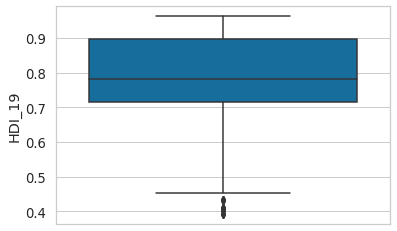

In [10]:
sns.boxplot(y=hdi)

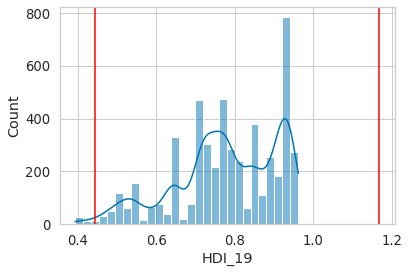

In [11]:
sns.histplot(data=siei, x=hdi, kde=True)
plt.axvline(tukey_fences(hdi)[1], 0,1, color="red")
plt.axvline(tukey_fences(hdi)[0], 0,1, color="red")

### 3.2 HDI (Country values)

In [12]:
hdi = pd.Series(siei_c_mean['HDI_19'])

print(f"Min val.: {np.array(hdi).min()}")
print(f"Q25: {hdi.quantile(0.25)}")
print(f"Q50 (Mean): {hdi.quantile(0.50)}")
print(f"Q75: {hdi.quantile(0.75)}")
print(f"Max val.: {np.array(hdi).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(hdi)[1]}, {tukey_fences(hdi)[0]}")

Min val.: 0.393
Q25: 0.59875
Q50 (Mean): 0.747
Q75: 0.85275
Max val.: 0.962

Outlier fences (Lo/Up): 0.21775, 1.2337500000000001


<AxesSubplot:ylabel='HDI_19'>

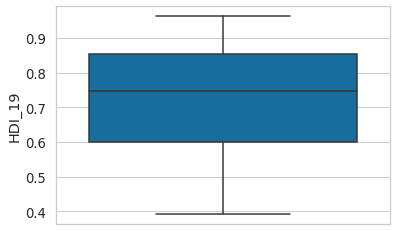

In [13]:
sns.boxplot(y=hdi)

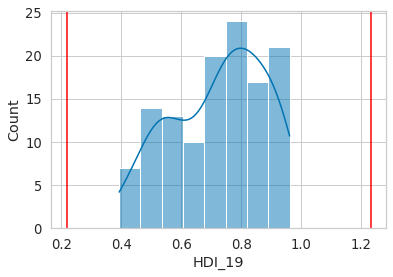

In [14]:
sns.histplot(data=siei, x=hdi, kde=True)
plt.axvline(tukey_fences(hdi)[1], 0,1, color="red")
plt.axvline(tukey_fences(hdi)[0], 0,1, color="red")

### 3.3 GDP (All values)

In [15]:
gdp = siei['GDP_19']

print(f"Min val.: {np.array(gdp).min}")
print(f"Q25: {gdp.quantile(0.25)}")
print(f"Q50 (Mean): {gdp.quantile(0.50)}")
print(f"Q75: {gdp.quantile(0.75)}")
print(f"Max val.: {np.array(gdp).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(gdp)[1]}, {tukey_fences(gdp)[0]}")

Min val.: <built-in method min of numpy.ndarray object at 0x7f634fc72b10>
Q25: 3398.214
Q50 (Mean): 7842.602
Q75: 29576.25
Max val.: 84476.471

Outlier fences (Lo/Up): -35868.840000000004, 68843.304


<AxesSubplot:ylabel='GDP_19'>

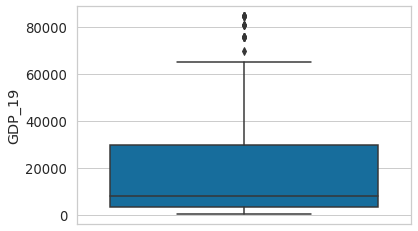

In [16]:
sns.boxplot(y=gdp)

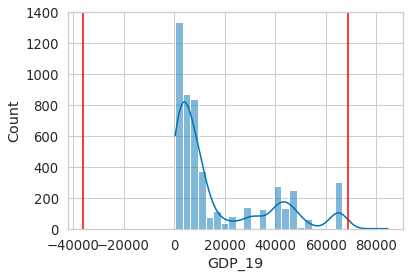

In [17]:
sns.histplot(data=siei, x=gdp, kde=True)
plt.axvline(tukey_fences(gdp)[1], 0,1, color="red")
plt.axvline(tukey_fences(gdp)[0], 0,1, color="red")

### 3.4 GDP (Country values)

In [18]:
gdp = pd.Series(siei_c_mean['GDP_19'])

print(f"Min val.: {np.array(gdp).min()}")
print(f"Q25: {gdp.quantile(0.25)}")
print(f"Q50 (Mean): {gdp.quantile(0.50)}")
print(f"Q75: {gdp.quantile(0.75)}")
print(f"Max val.: {np.array(gdp).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(gdp)[1]}, {tukey_fences(gdp)[0]}")

Min val.: 397.572
Q25: 1752.595
Q50 (Mean): 5563.4215
Q75: 15839.894
Max val.: 84476.471

Outlier fences (Lo/Up): -19378.3535, 36970.8425


<AxesSubplot:ylabel='GDP_19'>

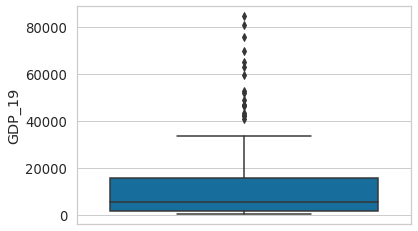

In [19]:
sns.boxplot(y=gdp)

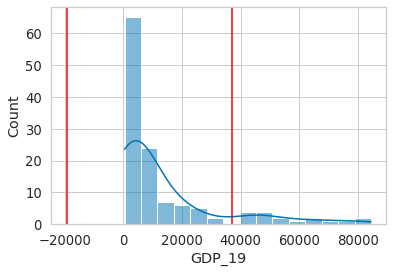

In [20]:
sns.histplot(data=siei, x=gdp, kde=True)
plt.axvline(tukey_fences(gdp)[1], 0,1, color="red")
plt.axvline(tukey_fences(gdp)[0], 0,1, color="red")

### 3.6 LogGDP (All values)

In [21]:
gdp = np.log(siei['GDP_19'])

print(f"Min val.: {np.array(gdp).min}")
print(f"Q25: {gdp.quantile(0.25)}")
print(f"Q50 (Mean): {gdp.quantile(0.50)}")
print(f"Q75: {gdp.quantile(0.75)}")
print(f"Max val.: {np.array(gdp).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(gdp)[1]}, {tukey_fences(gdp)[0]}")

Min val.: <built-in method min of numpy.ndarray object at 0x7f634fa696f0>
Q25: 8.131005278471315
Q50 (Mean): 8.967325946036997
Q75: 10.29472695338031
Max val.: 11.344228324866807

Outlier fences (Lo/Up): 4.885422766107823, 13.540309465743803


<AxesSubplot:ylabel='GDP_19'>

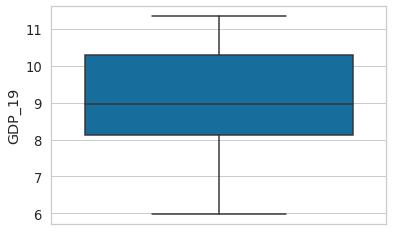

In [22]:
sns.boxplot(y=gdp)

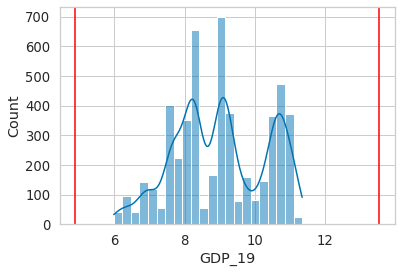

In [23]:
sns.histplot(data=siei, x=gdp, kde=True)
plt.axvline(tukey_fences(gdp)[1], 0,1, color="red")
plt.axvline(tukey_fences(gdp)[0], 0,1, color="red")

### 3.7 LogGDP (Country values)

In [24]:
gdp = np.log(pd.Series(siei_c_mean['GDP_19']))

print(f"Min val.: {np.array(gdp).min()}")
print(f"Q25: {gdp.quantile(0.25)}")
print(f"Q50 (Mean): {gdp.quantile(0.50)}")
print(f"Q75: {gdp.quantile(0.75)}")
print(f"Max val.: {np.array(gdp).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(gdp)[1]}, {tukey_fences(gdp)[0]}")

Min val.: 5.985376049767424
Q25: 7.468724991130193
Q50 (Mean): 8.6231977060914
Q75: 9.67027846189581
Max val.: 11.344228324866807

Outlier fences (Lo/Up): 4.166394784981767, 12.972608668044236


<AxesSubplot:ylabel='GDP_19'>

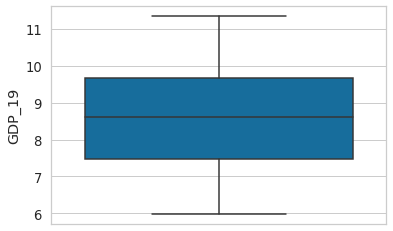

In [25]:
sns.boxplot(y=gdp)

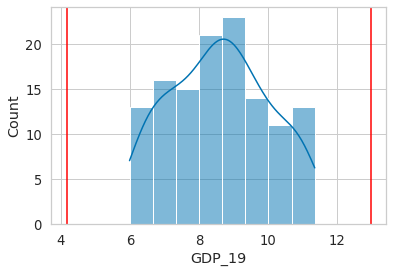

In [26]:
sns.histplot(data=siei, x=gdp, kde=True)
plt.axvline(tukey_fences(gdp)[1], 0,1, color="red")
plt.axvline(tukey_fences(gdp)[0], 0,1, color="red")

### 3.8 Target features building (HDI & Log GDP unique values)

In [27]:
# Building new feature: Log GDP

siei['LogGDP_19'] = np.log(siei['GDP_19'])
siei_c_mean['LogGDP_19'] = np.log(siei_c_mean['GDP_19'])

In [28]:
# Defining relevant boundaries for target feature building

gdp = pd.Series(siei_c_mean['LogGDP_19'])
hdi = pd.Series(siei_c_mean['HDI_19'])

boundaries_gdp = np.array([gdp.quantile(0.25), gdp.quantile(0.50), gdp.quantile(0.75)])
boundaries_hdi = np.array([hdi.quantile(0.25), hdi.quantile(0.50), hdi.quantile(0.75)])

# Building the features

hdi_group = []
gdp_group = []

for i in range(siei.shape[0]):
    hdi_i = siei.iloc[i][6]
    loggdp_i = siei.iloc[i][9]
    
    if hdi_i < boundaries_hdi[0]:
        hdi_group.append(1)
    elif hdi_i < boundaries_hdi[1]:
        hdi_group.append(2)
    elif hdi_i < boundaries_hdi[2]:
        hdi_group.append(3)
    else:
        hdi_group.append(4)
        
    if loggdp_i < boundaries_gdp[0]:
        gdp_group.append(1)
    elif loggdp_i < boundaries_gdp[1]:
        gdp_group.append(2)
    elif loggdp_i < boundaries_gdp[2]:
        gdp_group.append(3)
    else:
        gdp_group.append(4)
        
siei['target_HDI'] = hdi_group
siei['target_LogGDP'] = gdp_group

# Siei_c_mean recomputed to incorporate in it all newly built features

siei_c_mean = siei.groupby("country").mean()

### 3.9 Traget features exploration

In [29]:
# Target features in siei and siei_c_mean transformed into categorical for visualization clarity purposes

siei['target_HDI'] = pd.Categorical(siei['target_HDI'], [1,2,3,4])
siei['target_LogGDP'] = pd.Categorical(siei['target_LogGDP'], [1,2,3,4])

siei_c_mean['target_HDI'] = pd.Categorical(siei_c_mean['target_HDI'], [1,2,3,4])
siei_c_mean['target_LogGDP'] = pd.Categorical(siei_c_mean['target_LogGDP'], [1,2,3,4])

#### 3.9.1 `target_HDI`

<AxesSubplot:xlabel='target_HDI', ylabel='Count'>

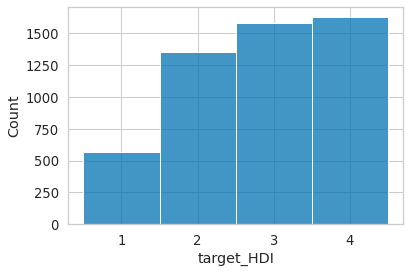

In [30]:
sns.histplot(siei['target_HDI'].apply(lambda x: str(x)))

In [31]:
print(f"Countries included in target_HDI 1: \n \n {siei_c_mean[siei_c_mean['target_HDI'] == 1].index}")
print("---")
print(f"Countries included in target_HDI 2: \n \n {siei_c_mean[siei_c_mean['target_HDI'] == 2].index}")
print("---")
print(f"Countries included in target_HDI 3: \n \n {siei_c_mean[siei_c_mean['target_HDI'] == 3].index}")
print("---")
print(f"Countries included in target_HDI 4: \n \n {siei_c_mean[siei_c_mean['target_HDI'] == 4].index}")

Countries included in target_HDI 1: 
 
 Index(['afghanistan', 'benin', 'burkinafaso', 'cambodia', 'cameroon',
       'centralafrica', 'chad', 'drcongo', 'eritrea', 'ethiopia', 'guinea',
       'haiti', 'ivorycoast', 'kenya', 'madagascar', 'malawi', 'mali',
       'mauritania', 'mozambique', 'niger', 'nigeria', 'pakistan',
       'papuanewguinea', 'rwanda', 'senegal', 'sierraleone', 'southsudan',
       'sudan', 'tanzania', 'togo', 'uganda', 'zambia'],
      dtype='object', name='country')
---
Countries included in target_HDI 2: 
 
 Index(['bangladesh', 'bolivia', 'botswana', 'egypt', 'elsalvador',
       'equatorialguinea', 'gabon', 'ghana', 'guatemala', 'guyana', 'honduras',
       'india', 'indonesia', 'jamaica', 'jordan', 'kyrgyzstan', 'laos',
       'lebanon', 'mongolia', 'morocco', 'namibia', 'nepal', 'nicaragua',
       'paraguay', 'philippines', 'tajikistan', 'tunisia', 'uzbekistan',
       'venezuela', 'vietnam', 'zimbabwe'],
      dtype='object', name='country')
---
Countries 

#### 3.9.2 `target_GDP`

<AxesSubplot:xlabel='target_LogGDP', ylabel='Count'>

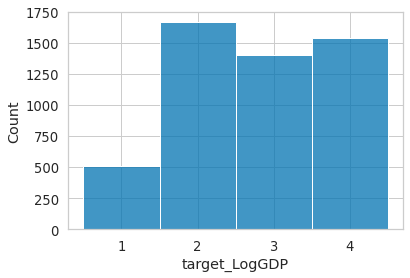

In [32]:
sns.histplot(siei['target_LogGDP'].apply(lambda x: str(x)))

In [33]:
print(f"Countries included in target_LogGDP 1: \n \n {siei_c_mean[siei_c_mean['target_LogGDP'] == 1].index}")
print("---")
print(f"Countries included in target_LogGDP 2: \n \n {siei_c_mean[siei_c_mean['target_LogGDP'] == 2].index}")
print("---")
print(f"Countries included in target_LogGDP 3: \n \n {siei_c_mean[siei_c_mean['target_LogGDP'] == 3].index}")
print("---")
print(f"Countries included in target_LogGDP 4: \n \n {siei_c_mean[siei_c_mean['target_LogGDP'] == 4].index}")

Countries included in target_LogGDP 1: 
 
 Index(['afghanistan', 'benin', 'burkinafaso', 'cambodia', 'cameroon',
       'centralafrica', 'chad', 'drcongo', 'eritrea', 'ethiopia', 'guinea',
       'haiti', 'ivorycoast', 'kyrgyzstan', 'madagascar', 'malawi', 'mali',
       'mozambique', 'nepal', 'niger', 'pakistan', 'rwanda', 'senegal',
       'sierraleone', 'southsudan', 'sudan', 'tajikistan', 'tanzania', 'togo',
       'uganda', 'zambia', 'zimbabwe'],
      dtype='object', name='country')
---
Countries included in target_LogGDP 2: 
 
 Index(['albania', 'algeria', 'azerbaijan', 'bangladesh', 'bolivia', 'egypt',
       'elsalvador', 'georgia', 'ghana', 'guatemala', 'honduras', 'india',
       'indonesia', 'jordan', 'kenya', 'laos', 'mauritania', 'mongolia',
       'morocco', 'namibia', 'nicaragua', 'nigeria', 'papuanewguinea',
       'paraguay', 'philippines', 'srilanka', 'tunisia', 'ukraine',
       'uzbekistan', 'venezuela', 'vietnam'],
      dtype='object', name='country')
---
Countri

#### 3.9.3 Instances in  `target_HDI` vs `target_LogGDP` 

In [34]:
target_diferences = siei[siei['target_HDI'] != siei['target_LogGDP']]
target_diferences["target_diff"] = siei['target_HDI'].cat.codes - siei['target_LogGDP'].cat.codes
target_diferences[['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
0,3,2,1
1,3,2,1
2,3,2,1
3,3,2,1
4,3,2,1
...,...,...,...
5108,3,2,1
5109,3,2,1
5110,3,2,1
5124,1,2,-1


Instances whose GDP class is higher than their HDI class

In [35]:
target_diferences[target_diferences["target_diff"] == -1][['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
177,2,3,-1
178,2,3,-1
179,2,3,-1
180,2,3,-1
181,2,3,-1
...,...,...,...
3318,3,4,-1
3319,3,4,-1
3320,3,4,-1
5124,1,2,-1


Instances whose HDI class is higher than their GDP class

In [36]:
target_diferences[target_diferences["target_diff"] == 1][['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
0,3,2,1
1,3,2,1
2,3,2,1
3,3,2,1
4,3,2,1
...,...,...,...
5106,3,2,1
5107,3,2,1
5108,3,2,1
5109,3,2,1


#### 3.9.4 Countries in  `target_HDI` vs `target_LogGDP` 

Observing which countries are assigned different labels for the HDI and GDP inicators. This difference is never larger than 1 class up/down.

The results show that 26 out of 126 countries have non-coincident class labels for the reference indicators. That slightly above 20% of the countries listed.

In [37]:
target_diferences = siei_c_mean[siei_c_mean['target_HDI'] != siei_c_mean['target_LogGDP']]
target_diferences["target_diff"] = siei_c_mean['target_HDI'].cat.codes - siei_c_mean['target_LogGDP'].cat.codes
target_diferences[['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
country,,,
albania,3,2,1
algeria,3,2,1
azerbaijan,3,2,1
botswana,2,3,-1
chile,4,3,1
croatia,4,3,1
equatorialguinea,2,3,-1
gabon,2,3,-1
georgia,3,2,1


Countries whose GDP class is higher than their HDI class

In [38]:
target_diferences[target_diferences["target_diff"] == -1][['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
country,,,
botswana,2,3,-1
equatorialguinea,2,3,-1
gabon,2,3,-1
guyana,2,3,-1
jamaica,2,3,-1
kenya,1,2,-1
lebanon,2,3,-1
mauritania,1,2,-1
nigeria,1,2,-1


Countries whose HDI class is higher than their GDP class

In [39]:
target_diferences[target_diferences["target_diff"] == 1][['target_HDI', 'target_LogGDP', 'target_diff']]

,target_HDI,target_LogGDP,target_diff
country,,,
albania,3,2,1
algeria,3,2,1
azerbaijan,3,2,1
chile,4,3,1
croatia,4,3,1
georgia,3,2,1
kyrgyzstan,2,1,1
nepal,2,1,1
poland,4,3,1


### 3.X Key takeaways

HDI reference indicators is employed as baseline for the target feature target_HDI, while reference indicator GDP is transformed into LogGDP to build the target feature target_LogGDP. The reason behind this is the common practice in economics of taking the natural logarithm of GDP which among other reasons, in this case allows to improve the comparison capacity accorss intances in such a wide and uneven distribution as GDP per capita. 

In total two target features (class label features) are built, one for each reference indicator. 12% of instances (from/correspnding to 20% of the countries in the sample) where asisgned different labels for each target indicator, which implies that the instances  whose show this difference in assignation tend to come from countries which relatively low number of instances. This difference was never larger than one class accross (i.e. nevar larger/smaller than +/-1).

When observing the distributon of the baseline features for the construction of the target class labels (HDI and LogGdp), no outliers are observed and the distributions are approximately bell shaped.

Figures under section 3.9.1 and 3.9.2 signal the existence of a problem of class imbalance regarding class 1 of both the GDP target indicator and the HDI target indicator.

## 4. Population

In [40]:
siei

,cityname,country,latest_figure,figure_description,town_code,GDP_19,HDI_19,year_latest_figure,2019_figure_est,LogGDP_19,target_HDI,target_LogGDP
0,Adrar,algeria,68276,(C)2008-04-14Area,0,3953.576,0.748,2008,84344,8.282376,3,2
1,Aflou,algeria,93585,(C)2008-04-14Area,1,3953.576,0.748,2008,115609,8.282376,3,2
2,Aïn Béïda,algeria,116064,(C)2008-04-14Area,2,3953.576,0.748,2008,143379,8.282376,3,2
3,Aïn Defla,algeria,55259,(C)2008-04-14Area,3,3953.576,0.748,2008,68263,8.282376,3,2
4,Aïn M'lila,algeria,65371,(C)2008-04-14Area,4,3953.576,0.748,2008,80755,8.282376,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5121,Tauranga,newzealand,158300,(Ep)2022-06-30Area,5488,42342.994,0.937,2022,151392,10.653558,4,4
5122,Wellington,newzealand,212000,(Ep)2022-06-30Area,5489,42342.994,0.937,2022,202749,10.653558,4,4
5123,Whangārei,newzealand,54900,(Ep)2022-06-30Area,5490,42342.994,0.937,2022,52504,10.653558,4,4
5124,Lae,papuanewguinea,148934,(Cf)2011-07-10Area,5491,2877.577,0.560,2011,182050,7.964704,1,2


### 4.1 Instances distribution by population

#### 4.1.1 `latest_figure`

Total population measured by 'latest_figure': 736.497.106

In [41]:
siei['latest_figure'].sum()

736497106

In [42]:
lf = siei['latest_figure']

print(f"Min val.: {np.array(lf).min}")
print(f"Q25: {lf.quantile(0.25)}")
print(f"Q50 (Mean): {lf.quantile(0.50)}")
print(f"Q75: {lf.quantile(0.75)}")
print(f"Max val.: {np.array(lf).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(lf)[1]}, {tukey_fences(lf)[0]}")

Min val.: <built-in method min of numpy.ndarray object at 0x7f635178df30>
Q25: 73548.75
Q50 (Mean): 112505.0
Q75: 182321.5
Max val.: 498003

Outlier fences (Lo/Up): -89610.375, 345480.625


<AxesSubplot:ylabel='latest_figure'>

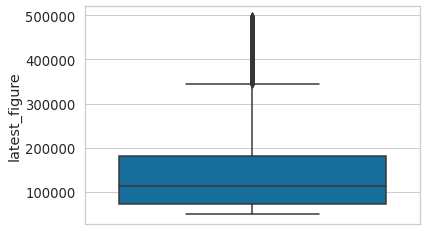

In [43]:
sns.boxplot(y=lf)

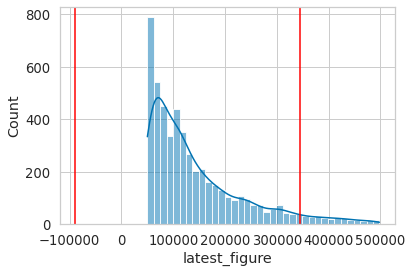

In [44]:
sns.histplot(data=siei, x=lf, kde=True)
plt.axvline(tukey_fences(lf)[1], 0,1, color="red")
plt.axvline(tukey_fences(lf)[0], 0,1, color="red")

#### 4.1.2 `2019_figure_est`

Total population measured by '2019_figure_est': 772.618.207

In [45]:
siei['2019_figure_est'].sum()

772618207

In [46]:
fe = siei['2019_figure_est']

print(f"Min val.: {np.array(fe).min}")
print(f"Q25: {fe.quantile(0.25)}")
print(f"Q50 (Mean): {fe.quantile(0.50)}")
print(f"Q75: {fe.quantile(0.75)}")
print(f"Max val.: {np.array(fe).max()}")
print('')
print(f"Outlier fences (Lo/Up): {tukey_fences(fe)[1]}, {tukey_fences(fe)[0]}")

Min val.: <built-in method min of numpy.ndarray object at 0x7f634f729d50>
Q25: 77882.25
Q50 (Mean): 116721.5
Q75: 191836.5
Max val.: 499242

Outlier fences (Lo/Up): -93049.125, 362767.875


<AxesSubplot:ylabel='2019_figure_est'>

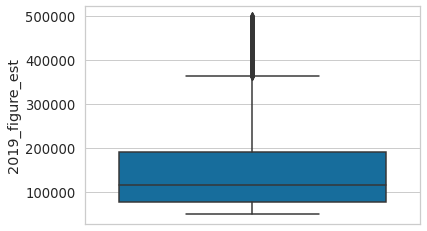

In [47]:
sns.boxplot(y=fe)

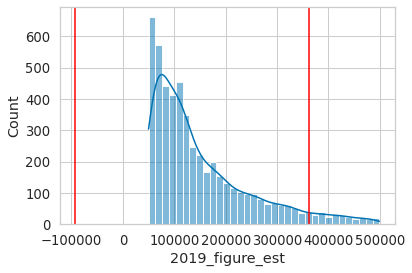

In [48]:
sns.histplot(data=siei, x=fe, kde=True)
plt.axvline(tukey_fences(fe)[1], 0,1, color="red")
plt.axvline(tukey_fences(fe)[0], 0,1, color="red")

In [49]:
# New feature to account for population outliers

siei["2019_figure_est_outlier"] = (siei['2019_figure_est'] > 362768).astype(int)

### 4.2 Population (`2019_figure_est`) and target features

The main point in this section will be to check the lack of correlation between target features and population (pandas pairwise correlation method employed).

As expected, in both cases population is very close to 0.

In [50]:
corr_pop_LogGDP = siei['2019_figure_est'].corr(siei['target_LogGDP'].cat.codes)
corr_pop_LogGDP

-0.0014505178944415368

In [51]:
corr_pop_HDI = siei['2019_figure_est'].corr(siei['target_HDI'].cat.codes)
corr_pop_HDI

-0.02278463010906255

### 4.3 Other exploratory excercises related to population figures

Top 10 countries by total population of the instances included in the sample (Number of instances included as well)

The notiof of India having a total population in the sample slightly larger than that of the US despite having only 2/3 the number of instances suggests that india is contributing to the sampel instances which are larger in terms of population than the US. This may happen for other countries, however given that the overall correlation between instance population and the target features is close to 0 this should not be a source of concern.

Such differences in terms of the average sizes of the instances by country may be derived from the way in which different national statistics bureaus elaborate the population tables from which this project's sample was built.

In [52]:
siei_for_c_sum = siei.copy()
siei_for_c_sum['total_instances'] = 1
siei_c_sum = siei_for_c_sum.groupby("country").sum()
siei_c_sum[['2019_figure_est', 'total_instances']].sort_values('2019_figure_est', ascending=False).head(15)

,2019_figure_est,total_instances
country,,
india,54210646,206
usa,54188417,307
brazil,47305370,238
japan,47052753,231
indonesia,38773855,259
russia,27654743,130
algeria,22584176,164
iran,22025359,165
turkey,21388990,164


Barplot with the top 30 countries by total population included in the sample

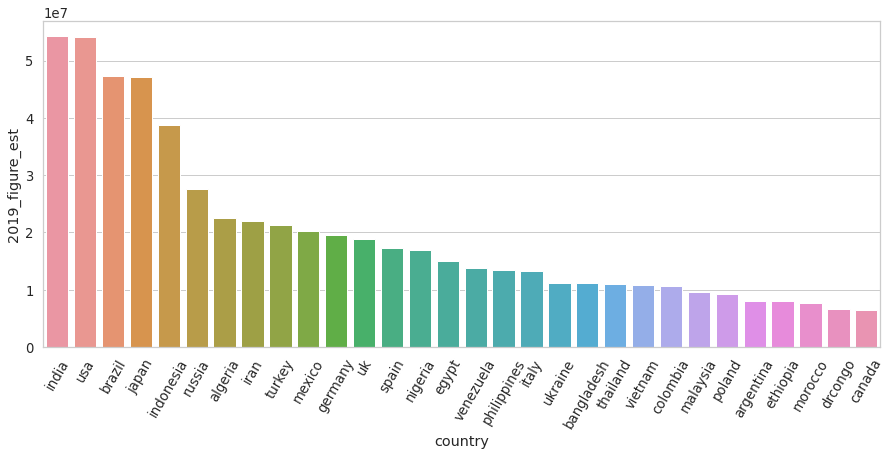

In [53]:
# Top 30 countries in the sample in terms of population

fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x=siei_c_sum[['2019_figure_est']].sort_values('2019_figure_est', ascending=False).index[:30], 
            y=siei_c_sum[['2019_figure_est']].sort_values('2019_figure_est', ascending=False)['2019_figure_est'][:30])

ax.set_xticklabels(ax.get_xticklabels(), rotation=60);

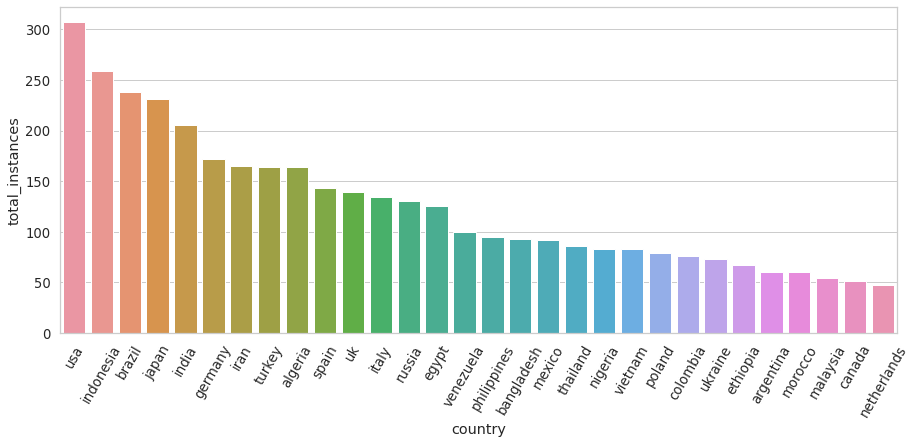

In [54]:
# Top 30 countries in the sample in terms of number of instances in the sample

fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x=siei_c_sum[['total_instances']].sort_values('total_instances', ascending=False).index[:30], 
            y=siei_c_sum[['total_instances']].sort_values('total_instances', ascending=False)['total_instances'][:30])

ax.set_xticklabels(ax.get_xticklabels(), rotation=60);

### 4.X Key takeaways

Population distributions are (unsurprisingly) heavily left-skewed. Moreover, the mean of `2019_figure_est` increases with respect to `lastest_figure` as expected given that the population projection for 2019 would have pushed some instances out of the sample as they get populations over 500k while no new instances that have newly reached 50k inhabitants are allowed to "enter" in the sample. 

Considering that `2019_figure_est` is the reference feature por demographics in this project, the analysis of this is deemed of higher relevance thant hat of `latest_figure`beyond the transformation that leads for one to the other. For `2019_figure_est`, instances with over 362k inhabitants are considered outliers in term of population. A new feature is added to siei to account for this fact and signal which instances are outliers in terms of population.

### X.X Saving resulting processed DF 

In [55]:
siei.to_csv("../data/siei_processed_v1.csv")

### X.X Collection of notes (Unordered - Last update 20/04/23)

HDI reference indicators is employed as baseline for the target feature target_HDI, while reference indicator GDP is transformed into LogGDP to build the target feature target_LogGDP. The reason behind this is the common practice in economics of taking the natural logarithm of GDP which among other reasons, in this case allows to improve the comparison capacity accorss intances in such a wide and uneven distribution as GDP per capita. 

In total two target features (class label features) are built, one for each reference indicator. 12% of instances (from/correspnding to 20% of the countries in the sample) where asisgned different labels for each target indicator, which implies that the instances  whose show this difference in assignation tend to come from countries which relatively low number of instances. This difference was never larger than one class accross (i.e. nevar larger/smaller than +/-1).

When observing the distributon of the baseline features for the construction of the target class labels (HDI and LogGdp), no outliers are observed and the distributions are approximately bell shaped.

Figures under section 3.9.1 and 3.9.2 signal the existence of a problem of class imbalance regarding class 1 of both the GDP target indicator and the HDI target indicator.

The notion of India having a total population in the sample slightly larger than that of the US despite having only 2/3 the number of instances suggests that india is contributing to the sampel instances which are larger in terms of population than the US. This may happen for other countries, however given that the overall correlation between instance population and the target features is close to 0 this should not be a source of concern.

Such differences in terms of the average sizes of the instances by country may be derived from the way in which different national statistics bureaus elaborate the population tables from which this project's sample was built.

Population distributions are (unsurprisingly) heavily left-skewed. Moreover, the mean of 2019_figure_est increases with respect to lastest_figure as expected given that the population projection for 2019 would have pushed some instances out of the sample as they get populations over 500k while no new instances that have newly reached 50k inhabitants are allowed to "enter" in the sample.

Considering that 2019_figure_est is the reference feature por demographics in this project, the analysis of this is deemed of higher relevance thant hat of latest_figurebeyond the transformation that leads for one to the other. For 2019_figure_est, instances with over 362k inhabitants are considered outliers in term of population. A new feature is added to siei to account for this fact and signal which instances are outliers in terms of population.